In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('extracted_data_updated.csv')

data = pd.read_csv('./extracted/combined.csv')
data

,route_id,vehicle_id,stop_id,delay,scheduled_time,actual_time,day
0,3,3514.0,1358,645,81439,82084,1
1,3,3514.0,1359,645,81480,82125,1
2,3,3514.0,12,645,81531,82176,1
3,3,3519.0,28,-75,82197,82122,1
4,3,3519.0,734,-75,82251,82176,1
...,...,...,...,...,...,...,...
12883360,10,3503.0,31,480,81718,82198,1
12883361,10,3510.0,1356,555,81578,82133,1
12883362,10,3510.0,1357,555,81607,82162,1
12883363,10,3510.0,680,555,81642,82197,1


In [2]:
data['actual_time_12hr'] = data['actual_time']
data['actual_delay'] = data['delay']
data = data[[ 'actual_time_12hr', 'actual_delay']]
data

,actual_time_12hr,actual_delay
0,82084,645
1,82125,645
2,82176,645
3,82122,-75
4,82176,-75
...,...,...
12883360,82198,480
12883361,82133,555
12883362,82162,555
12883363,82197,555


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

/tmp/ipykernel_2248505/2773050771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['actual_time_12hr'] = data['actual_time_12hr'].apply(
/tmp/ipykernel_2248505/2773050771.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['actual_time_12hr'] = pd.to_datetime(data['actual_time_12hr']).dt.hour
/tmp/ipykernel_2248505/2773050771.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

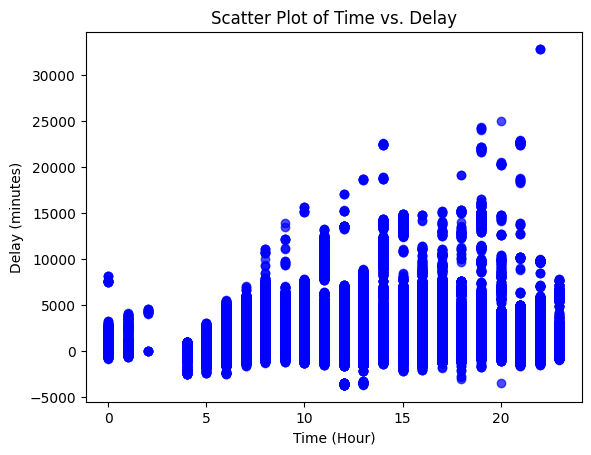

In [4]:
from datetime import datetime
data['actual_time_12hr'] = data['actual_time_12hr'].apply(
    lambda ts: datetime.fromtimestamp(ts).strftime("%I:%M:%S %p")
)

data['actual_time_12hr'] = pd.to_datetime(data['actual_time_12hr']).dt.hour
# Scatter plot
plt.scatter(data['actual_time_12hr'], data['actual_delay'], color='blue', alpha=0.7)

# Adding labels and title
plt.xlabel('Time (Hour)')
plt.ylabel('Delay (minutes)')
plt.title('Scatter Plot of Time vs. Delay')

# Show the plot
plt.show()


In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('actual_time_12hr', inplace=True)

    for i in range(1, n_steps+1):
        df[f'actual_delay(t-{i})'] = df['actual_delay'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 24
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,actual_delay,actual_delay(t-1),actual_delay(t-2),actual_delay(t-3),actual_delay(t-4),actual_delay(t-5),actual_delay(t-6),actual_delay(t-7),actual_delay(t-8),actual_delay(t-9),...,actual_delay(t-15),actual_delay(t-16),actual_delay(t-17),actual_delay(t-18),actual_delay(t-19),actual_delay(t-20),actual_delay(t-21),actual_delay(t-22),actual_delay(t-23),actual_delay(t-24)
actual_time_12hr,,,,,,,,,,,,,,,,,,,,,
17,-30,-30.0,-30.0,-15.0,-15.0,2711.0,2711.0,105.0,105.0,900.0,...,0.0,0.0,615.0,615.0,615.0,-75.0,-75.0,645.0,645.0,645.0
17,-45,-30.0,-30.0,-30.0,-15.0,-15.0,2711.0,2711.0,105.0,105.0,...,495.0,0.0,0.0,615.0,615.0,615.0,-75.0,-75.0,645.0,645.0
17,540,-45.0,-30.0,-30.0,-30.0,-15.0,-15.0,2711.0,2711.0,105.0,...,495.0,495.0,0.0,0.0,615.0,615.0,615.0,-75.0,-75.0,645.0
17,540,540.0,-45.0,-30.0,-30.0,-30.0,-15.0,-15.0,2711.0,2711.0,...,900.0,495.0,495.0,0.0,0.0,615.0,615.0,615.0,-75.0,-75.0
17,353,540.0,540.0,-45.0,-30.0,-30.0,-30.0,-15.0,-15.0,2711.0,...,900.0,900.0,495.0,495.0,0.0,0.0,615.0,615.0,615.0,-75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,480,480.0,45.0,919.0,0.0,0.0,0.0,60.0,60.0,600.0,...,-15.0,-15.0,-105.0,-105.0,-105.0,165.0,165.0,165.0,165.0,615.0
17,555,480.0,480.0,45.0,919.0,0.0,0.0,0.0,60.0,60.0,...,165.0,-15.0,-15.0,-105.0,-105.0,-105.0,165.0,165.0,165.0,165.0
17,555,555.0,480.0,480.0,45.0,919.0,0.0,0.0,0.0,60.0,...,285.0,165.0,-15.0,-15.0,-105.0,-105.0,-105.0,165.0,165.0,165.0


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ -30.,  -30.,  -30., ...,  645.,  645.,  645.],
       [ -45.,  -30.,  -30., ...,  -75.,  645.,  645.],
       [ 540.,  -45.,  -30., ...,  -75.,  -75.,  645.],
       ...,
       [ 555.,  555.,  480., ...,  165.,  165.,  165.],
       [ 555.,  555.,  555., ..., -105.,  165.,  165.],
       [   0.,  555.,  555., ..., -105., -105.,  165.]])

In [7]:
shifted_df_as_np.shape

(12883341, 25)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.80073922, -0.80073922, -0.80073922, ..., -0.76377823,
        -0.76377823, -0.76377823],
       [-0.80156057, -0.80073922, -0.80073922, ..., -0.80320329,
        -0.76377823, -0.76377823],
       [-0.76952772, -0.80156057, -0.80073922, ..., -0.80320329,
        -0.80320329, -0.76377823],
       ...,
       [-0.76870637, -0.76870637, -0.77281314, ..., -0.7900616 ,
        -0.7900616 , -0.7900616 ],
       [-0.76870637, -0.76870637, -0.76870637, ..., -0.804846  ,
        -0.7900616 , -0.7900616 ],
       [-0.79909651, -0.76870637, -0.76870637, ..., -0.804846  ,
        -0.804846  , -0.7900616 ]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((12883341, 24), (12883341,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.76377823, -0.76377823, -0.76377823, ..., -0.79991786,
        -0.80073922, -0.80073922],
       [-0.76377823, -0.76377823, -0.80320329, ..., -0.80073922,
        -0.80073922, -0.80073922],
       [-0.76377823, -0.80320329, -0.80320329, ..., -0.80073922,
        -0.80073922, -0.80156057],
       ...,
       [-0.7900616 , -0.7900616 , -0.7900616 , ..., -0.77281314,
        -0.77281314, -0.76870637],
       [-0.7900616 , -0.7900616 , -0.804846  , ..., -0.77281314,
        -0.76870637, -0.76870637],
       [-0.7900616 , -0.804846  , -0.804846  , ..., -0.76870637,
        -0.76870637, -0.76870637]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

12239173

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12239173, 24), (644168, 24), (12239173,), (644168,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12239173, 24, 1), (644168, 24, 1), (12239173, 1), (644168, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([12239173, 24, 1]),
 torch.Size([644168, 24, 1]),
 torch.Size([12239173, 1]),
 torch.Size([644168, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [23]:
from torch.utils.data import DataLoader

batch_size = 64000

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64000, 24, 1]) torch.Size([64000, 1])


In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [27]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [28]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.158

Val Loss: 0.289
***************************************************

Epoch: 2
Batch 100, Loss: 0.090

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 8
Batch 100, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 9
Batch 100, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.001
********************************

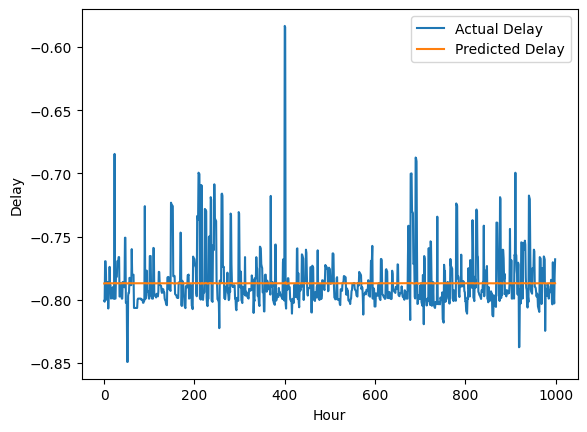

In [30]:
with torch.no_grad():
    predicted = model(X_train[:1000].to(device)).to('cpu').numpy()

plt.plot(y_train[:1000], label='Actual Delay')
plt.plot(predicted[:1000], label='Predicted Delay')
plt.xlabel('Hour')
plt.ylabel('Delay')
plt.legend()
plt.show()


In [32]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train[:1000].shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([219.24812919, 220.42591846, 221.06161988, 222.86422527,
       223.32249632, 222.15559235, 220.65886384, 220.46183994,
       221.60588479, 222.0695985 , 220.99957368, 221.32613263,
       221.88128284, 222.74230993, 222.19151384, 221.55581242,
       221.08339047, 221.08774459, 221.41321501, 221.63309804,
       222.12729058, 221.84427282, 221.60153067, 221.70385247,
       227.22487575, 222.82721525, 218.99559027, 220.64144737,
       221.58520272, 221.67990482, 222.23940915, 222.32322595,
       221.99993259, 221.92591256, 221.81379399, 220.22127485,
       219.88165355, 221.10080695, 221.70602953, 221.74739367,
       221.18135816, 221.07359371, 221.96074551, 222.26553386,
       222.05435908, 221.88672549, 221.59717655, 223.31487662,
       223.72634089, 220.41612169, 219.35045099, 220.26590458,
       218.98470497, 219.18064034, 222.86204821, 224.27713698,
       223.52278581, 223.35624075, 223.00355709, 222.19477943,
       221.80073163, 221.74303955, 223.03621298, 222.32

In [34]:
dummies = np.zeros((X_train[:1000].shape[0], lookback+1))
dummies[:, 0] = y_train[:1000].flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([-3.00001646e+01, -4.50001056e+01,  5.39999770e+02,  5.39999770e+02,
        3.53000143e+02, -1.50002236e+01, -1.50002236e+01,  2.39999862e+02,
        2.39999862e+02, -1.43000446e+02,  1.04000034e+02,  1.04000034e+02,
        4.59000089e+02,  1.95000039e+02,  1.95000039e+02, -2.82615423e-04,
        1.49996584e+01,  1.49996584e+01,  1.49996584e+01,  1.65000157e+02,
       -2.82615423e-04, -2.82615423e-04, -2.82615423e-04,  2.09100020e+03,
       -2.82615423e-04, -2.82615423e-04,  3.14999567e+02,  3.14999567e+02,
        3.14999567e+02,  5.39999770e+02,  5.39999770e+02,  5.39999770e+02,
        5.99999534e+02,  5.99999534e+02,  2.99995994e+01,  2.99995994e+01,
        2.24999921e+02,  2.24999921e+02,  2.24999921e+02, -2.82615423e-04,
       -2.82615423e-04,  2.39999862e+02,  2.39999862e+02,  2.39999862e+02,
        2.39999862e+02,  1.63999798e+02,  8.79999884e+02,  8.79999884e+02,
       -6.00000466e+01, -6.00000466e+01, -6.00000466e+01, -9.14999949e+02,
       -9.14999949e+02,  

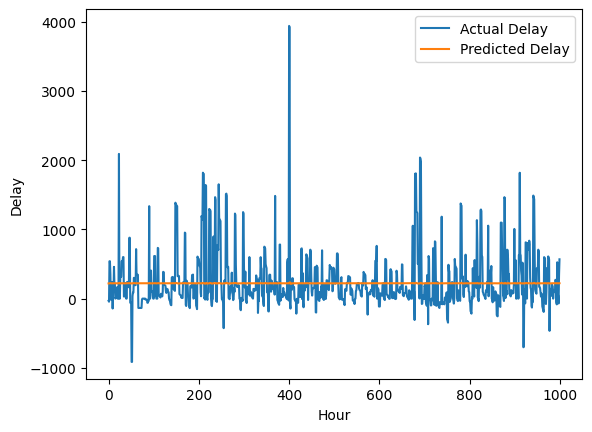

In [35]:
plt.plot(new_y_train, label='Actual Delay')
plt.plot(train_predictions, label='Predicted Delay')
plt.xlabel('Hour')
plt.ylabel('Delay')
plt.legend()
plt.show()


In [40]:
test_predictions = model(X_test[:1000].to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test[:1000].shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([221.99122435, 221.66248834, 221.5732289 , 222.28295034,
       222.35043919, 221.94986022, 220.92337659, 221.61023891,
       222.26117975, 221.6537801 , 221.39253294, 221.62330127,
       221.7778725 , 222.37003273, 222.06633291, 221.78331515,
       221.74957073, 221.71256071, 221.94768316, 221.98904729,
       223.08193123, 223.18860716, 221.98251611, 221.39797559,
       221.29347673, 221.33592939, 221.35225734, 221.46981856,
       221.54166153, 221.66684246, 221.77134132, 221.78440368,
       222.49412513, 222.63781106, 222.22525826, 221.9128502 ,
       221.8214137 , 221.3032735 , 221.11169225, 221.60370773,
       221.76916426, 221.68425894, 221.96618816, 222.54202044,
       222.84680879, 222.52895808, 222.11967087, 221.13019726,
       220.94732425, 221.51444829, 221.78222662, 221.73868543,
       221.88890254, 221.92591256, 221.81923664, 221.72453454,
       222.81306437, 223.14615449, 221.42954296, 220.96256366,
       221.93570933, 222.21763855, 221.99340141, 221.79

In [ ]:
dummies = np.zeros((X_test[:1000].shape[0], lookback+1))
dummies[:, 0] = y_test[:1000].flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 2.90003290e+01, -9.99951759e+00,  2.53000173e+02,  1.93000410e+02,
        1.60999810e+02, -2.04999839e+02,  1.47000228e+02,  1.50000216e+02,
       -4.50001056e+01, -6.70003819e+01, -4.50001056e+01, -5.59996995e+01,
        1.59000180e+02, -2.29998293e+01, -2.82615423e-04, -4.39997467e+01,
       -6.60000230e+01,  2.00043520e+00, -2.59998175e+01,  4.44000148e+02,
        4.09999919e+02,  1.92000051e+02,  1.59000180e+02,  9.60004283e+01,
        7.20005227e+01,  1.00000409e+01,  5.99969378e+00, -3.79997703e+01,
       -2.89998057e+01, -4.09997585e+01, -6.40003937e+01,  2.09999980e+02,
        1.99999656e+02,  1.75000480e+02,  1.47000228e+02,  1.56999463e+02,
       -5.20004409e+01, -9.19995579e+01, -2.82615423e-04, -5.20004409e+01,
       -9.19995579e+01, -2.82615423e-04,  1.80000098e+02,  2.99999626e+02,
        2.74000091e+02,  2.65000126e+02, -5.40000702e+01, -3.70004999e+01,
        3.20003172e+01,  2.39996230e+01, -1.69998529e+01,  3.99999229e+01,
        1.60000173e+01, -

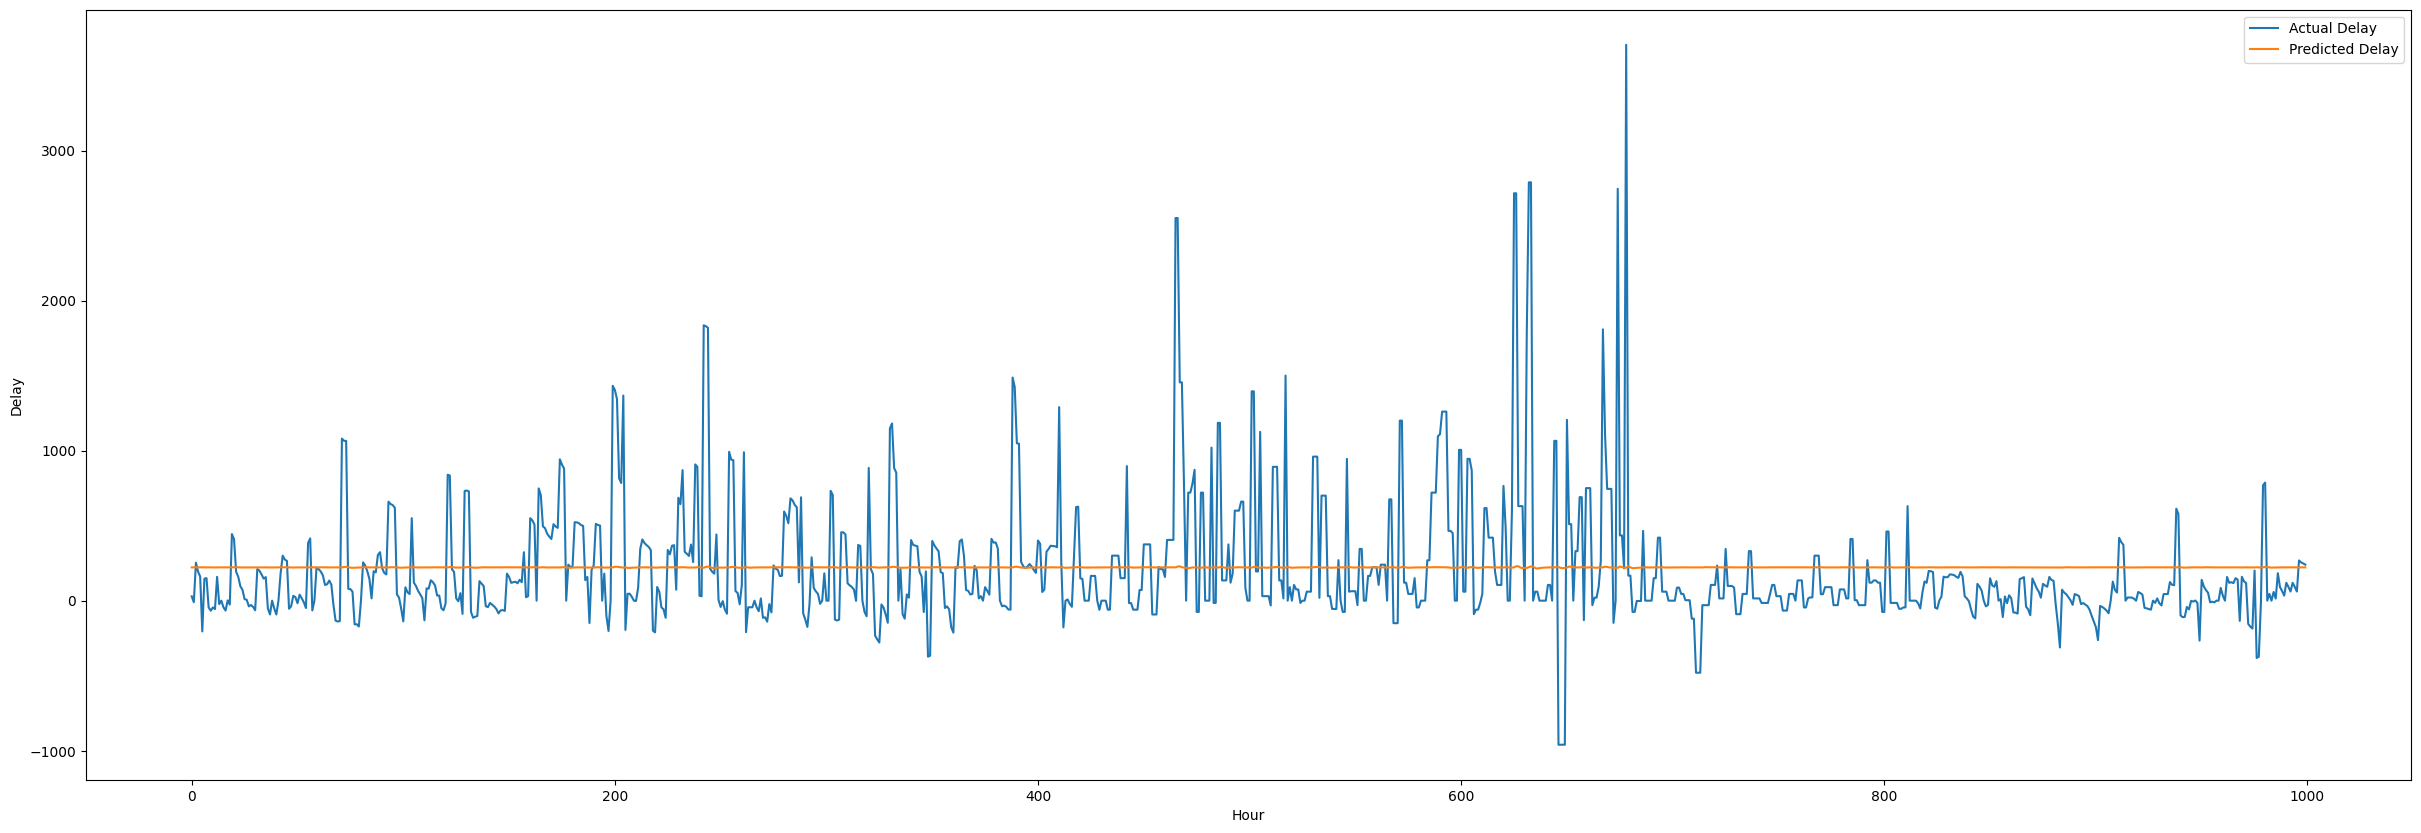

In [39]:
plt.figure(figsize=(30, 10))  # Adjust the width (12) and height (4) as needed

plt.plot(new_y_test, label='Actual Delay')
plt.plot(test_predictions, label='Predicted Delay')
plt.xlabel('Hour')
plt.ylabel('Delay')
plt.legend()
plt.show()
